# Evaluation


In [36]:
import sys
sys.path.append('../') #act as if we are one directory higher so imports work 
import torch
from latent_to_timestep_model import LTT_model
from dataset import load_data_from_dir
import numpy as np

In [52]:
path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0"
latents, targets, conditions, unconditions = load_data_from_dir(data_folder=path, limit=200)


## LTT Model

In [30]:
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0/final_ltt_model.pt", 10
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train50-rv12-seed0/ltt_model.pt", 10

model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 10
model_path, steps  = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N7-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 7
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N5-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 5
# model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N3-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 3


ltt_model = LTT_model(steps=steps)
state_dict = torch.load(model_path, weights_only=True)
ltt_model.load_state_dict(state_dict)  # Load the model state

<All keys matched successfully>

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(ltt_model))

19263606


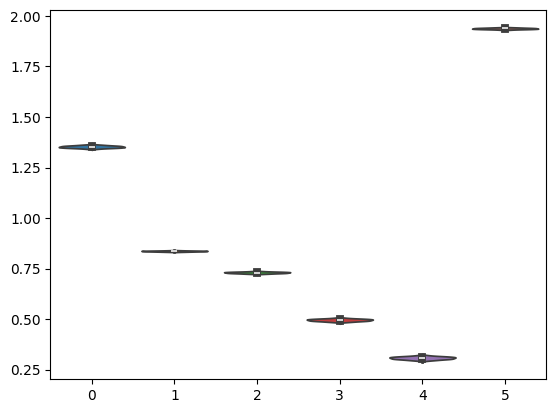

In [22]:
params_list = [ltt_model.forward(latent) for latent in latents]
params_list = torch.stack(params_list)

#visualize as violin plot over each of the 10 timesteps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

params_list = params_list.detach().numpy()
params_list = params_list.reshape(-1, steps+1)
params_list = pd.DataFrame(params_list, columns=[f"{i}" for i in range(steps+1)])
sns.violinplot(data=params_list)
plt.show()


In [23]:
params_list

,0,1,2,3,4,5
0,1.350336,0.837728,0.732342,0.498624,0.311475,1.936432
1,1.358233,0.834756,0.727248,0.490541,0.301588,1.940877
2,1.348769,0.838312,0.733349,0.500238,0.313467,1.935513
3,1.363316,0.832843,0.723976,0.485341,0.295314,1.943601
4,1.355395,0.835828,0.729089,0.493436,0.305115,1.939316
...,...,...,...,...,...,...
195,1.361471,0.833524,0.725141,0.487252,0.297604,1.942613
196,1.352274,0.836993,0.731084,0.496648,0.309041,1.937544
197,1.343206,0.840403,0.736939,0.505943,0.320563,1.932175
198,1.354964,0.835978,0.729343,0.493899,0.305672,1.939063


### U-net encoding

In [31]:
# Create a dictionary to store the output
hook_storage = {}

# Define the hook function using a closure
def get_hook(storage):
    def hook_fn(module, input, output):
        storage["unet_output"] = output  # Store output in the dictionary
    return hook_fn
# Register the hook on the UNet
hook_handle = ltt_model.unet.register_forward_hook(get_hook(hook_storage))

# Run the forward pass
output = ltt_model.forward(latents[0])

# Retrieve the stored UNet output
unet_output = hook_storage["unet_output"]
print("Stored UNet Output:", unet_output.shape)




Stored UNet Output: torch.Size([1, 1024, 2, 2])


In [38]:
def mse(tensor1, tensor2):
    return torch.mean((tensor1 - tensor2) ** 2)

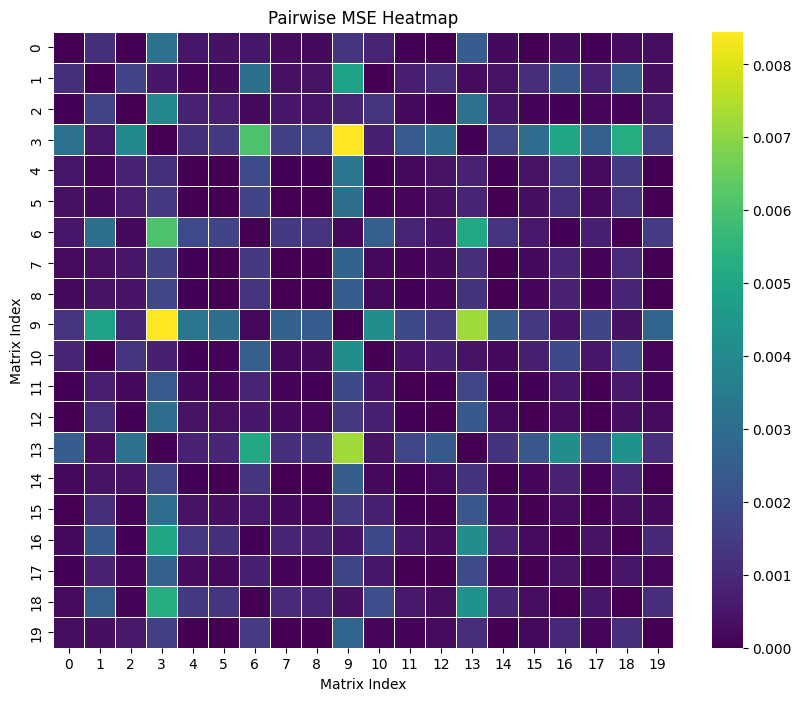

In [53]:
encodings = []
num_matrices = 20
for latent in latents[:num_matrices]:
    output = ltt_model.forward(latent)
    encodings.append(hook_storage["unet_output"])


mse_matrix = np.zeros((num_matrices, num_matrices))

for i in range(num_matrices):
    for j in range(num_matrices):
        mse_matrix[i, j] = mse(encodings[i], encodings[j])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mse_matrix, annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()



In [54]:
encodings[1]

tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[8.9047, 3.1766],
         [3.6043, 1.3548]],

        [[3.2127, 0.0000],
         [3.4294, 0.0000]]], grad_fn=<AsStridedBackward0>)

In [55]:
encodings[2]

tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[8.6716, 3.0921],
         [3.5086, 1.3199]],

        [[3.1303, 0.0000],
         [3.3395, 0.0000]]], grad_fn=<AsStridedBackward0>)

In [50]:
len(encodings)

1

In [46]:
mse(encodings[0], encodings[0])

tensor(0., grad_fn=<MeanBackward0>)

In [32]:
params_list = [ltt_model.forward(latent) for latent in latents]

In [33]:
unet_output = hook_storage["unet_output"]

In [35]:
unet_output.shape


torch.Size([1, 1024, 2, 2])